In [16]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from utils import *
from glob import glob
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter1d


def loadPreComputedCP(tensorname,basedir,specificFs=[],NMODES=3,verbose=True):
    
    """Converts the .mat files produced by tensor decomposition (see `matlab/run_permcp.m`)
    and aggregates the results from multiple choices of F (number of components) and
    initializations into a single Python dict."""
    
    
    preComputed = {}

    #parse the F (# of factors) from the file name
    def parseF(s):
        assert s[-4:] == '.mat'
        extn = 4
        F_str = s[:-extn].split('_rank')[-1]
        if '_r0_' in F_str:
            F_str, rep_str = F_str.split('_r0_')
            return int(F_str), int(rep_str)
        else:
            return int(F_str), 0  
        return int(F_str)
    
    query = '%s/%s/%s*_rank*.mat' % (basedir,tensorname,tensorname)
    queryfiles = glob(query)

    F_ = None
    counted_reps = 0
    for r in sorted(queryfiles):
        
        F, rep0 = parseF(r)

        if specificFs and F not in specificFs:
            continue

        if F != F_:
            if int(verbose) > 1:
                print()
            elif int(verbose) == 1 and counted_reps > 0:
                print(f'({counted_reps})',end=' ')
            
            counted_reps = 0 #reset
            
            if verbose: print(f'F{F}:',end=' ')
            F_ = F
        #if another file from the same F, keep updating the number of reps
        


        matfile = loadmat(r)
        assert matfile['factors'][0,0].shape[1] == NMODES

        nreps = len(matfile['factors'][0])

        factors = {rep0+rep:matfile['factors'][0][rep].squeeze() for rep in range(nreps)}
        lambdas = {rep0+rep:matfile['lams'][0][rep].squeeze() for rep in range(nreps)}
        objs = {rep0+rep:matfile['objs'][0][rep].squeeze() for rep in range(nreps)}


        F_precomp = {'all_factors':factors, 'all_lambdas':lambdas, 'all_objs':objs}


        counted_reps += nreps
        
        if F not in preComputed:
            preComputed[F] = F_precomp.copy()

        else:#merge results
            for dkey in F_precomp.keys():
                preComputed[F][dkey].update(F_precomp[dkey])

    if int(verbose) == 1 and counted_reps > 0:
        print(f'({counted_reps})')
        
    Fs = sorted(preComputed.keys())
    return preComputed,Fs


In [4]:
basedir = '../matlab/tensors'
tensorname = 'mouse-lgn-3xp_N225-nonNeg-relFRs-shiftdirs'
preComputed,Fs = loadPreComputedCP(tensorname,basedir)

F2: (31) F3: (31) F4: (31) F5: (31) F6: (31) F7: (31) F8: (31) F9: (31) F10: (31) F11: (31) F12: (31) F13: (31) F14: (31) F15: (31) F16: (31) F17: (31) F18: (31) F19: (31) F20: (31) F21: (31) F22: (31) F23: (31) F24: (31) F25: (31)


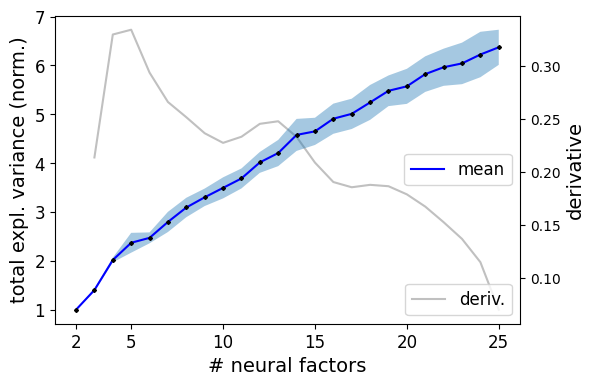

In [5]:
#plot total normalized explained variance (nuclear norm) for each F


nfacs = np.array(Fs)
NEURALMODE = 0
mus = []

stds = []

LGD_SZ = 12
LBL_SZ = 14
TICK_SZ = 12

for nf in nfacs:
    #collect factors for all available repetitions
    neuralfs = np.array([preComputed[nf]['all_factors'][repi][NEURALMODE] for repi in sorted(preComputed[nf]['all_factors'])])
    #normalize
    neuralfs = [f/from0to1(np.linalg.norm(f,axis=0,keepdims=1)) for f in neuralfs]
    
    nucl_norms = []
    
    reps_used = list(preComputed[nf]['all_lambdas'])###
    
    for repi in range(len(preComputed[nf]['all_factors'])):

        A = neuralfs[repi].copy()
        Si = A.T
        Si -= Si.mean(0)
        #compute explained variances
        s = np.linalg.svd(Si,full_matrices=False,compute_uv=False)
        var = s**2/(Si.shape[0]-1)   
        #normalize
        var /= var.max()
        # compute nuclear norm (sum of eigenvals)
        nucl_norms.append( var.sum() )

    mus.append(np.mean(nucl_norms))
    stds.append(np.std(nucl_norms))

f,ax1 = subps(1,1,4,6)
ax1.plot(nfacs, mus,'b-', label='mean')
ax1.plot(nfacs, mus,'kD',markersize=2)

mus = np.array(mus)
grads = np.diff(gaussian_filter1d(mus,1.5))
ax1_ = ax1.twinx()
ax1_.plot(nfacs[1:],grads,c='silver',label='deriv.',zorder=0)
ax1_.set_ylabel('derivative',size=LBL_SZ)
ax1_.legend(loc="lower right",fontsize=LGD_SZ)
stds = np.array(stds)
ax1.fill_between(nfacs,mus-stds,mus+stds,alpha=.4)
ax1.set_xlabel('# neural factors',size=LBL_SZ)
ax1.set_ylabel('total expl. variance (norm.)',size=LBL_SZ)
ax1.set_xticks([2]+list(range(5,26,5)))
ax1.tick_params(labelsize=TICK_SZ)
ax1.legend(loc="center right",fontsize=LGD_SZ)
ax1.set_zorder(ax1_.get_zorder()+1)
ax1.set_frame_on(False)

plt.show()

In [6]:
R = 5
rep, error = min(preComputed[R]['all_objs'].items(), key=lambda x: x[1])
print(f'The repetition with min error was #{rep} (% error = {error:.3f})')

The repetition with min error was #5 (% error = 7.742)


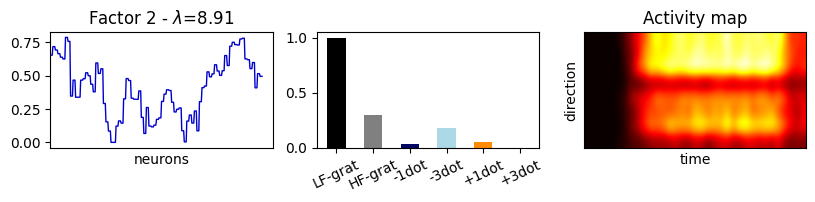

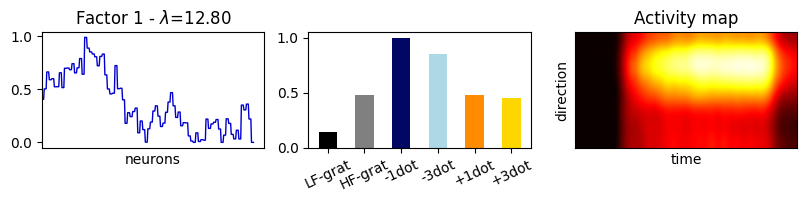

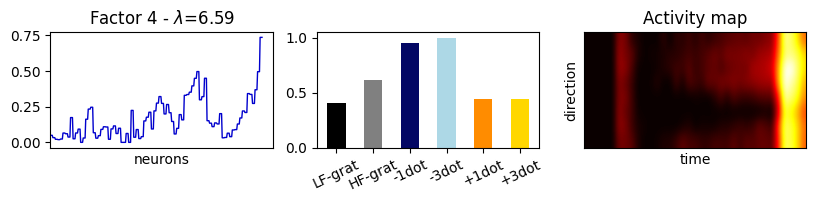

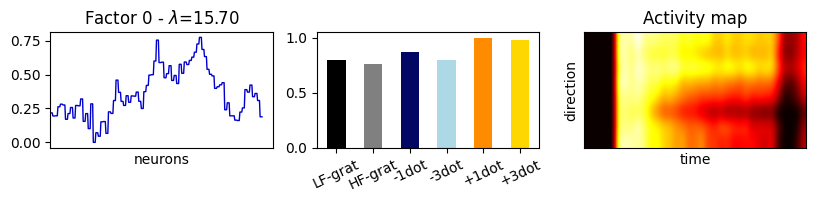

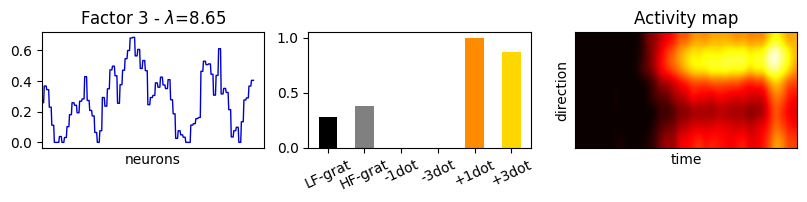

In [9]:
#PLOT FACTORS
from scipy.cluster.hierarchy import linkage,leaves_list,optimal_leaf_ordering
from scipy.spatial.distance import pdist

rep = 5
best_factors = preComputed[R]['all_factors'][rep]
best_lambdas = preComputed[R]['all_lambdas'][rep]



posnorms = ~np.isclose(best_lambdas,0)
best_lambdas = best_lambdas[posnorms]
nfactors = [f[:,posnorms]/np.linalg.norm(f[:,posnorms],axis=0,keepdims=1) for f in best_factors]



my_stims = ['LF-grat', 'HF-grat', '-1dot', '-3dot', '+1dot', '+3dot']

NSTIMS = len(my_stims)
NDIRS = 8


colors = ['k','gray','xkcd:darkblue','lightblue','darkorange','gold']
assert len(colors) >= NSTIMS

ncols = 3; colsz = 3.25
nrows = R; rowsz = 1.5

#sort factors by predominant stim (%)
sorted_factors = np.argsort((nfactors[1]).argmax(axis=0))
#sorted_factors = range(best_nfactors)

#rebalance factor loadings, scale by lambdas
stim_factors = nfactors[1].copy()
stim_scls = stim_factors.max(0,keepdims=1)
stim_factors /= stim_scls

neural_factors = nfactors[0].copy()
neural_factors *= best_lambdas
neural_factors *= stim_scls


#to improve visualization, find a global sorting of the neurons
# by running a hierarchical clustering based on the distance 
# between their neural coefficients across all components
flat_dist_mat = pdist(neural_factors)
Z = linkage(flat_dist_mat, method='complete')
leaves = leaves_list(optimal_leaf_ordering(Z, flat_dist_mat))


for ll,l in enumerate(sorted_factors):
    
    fig,axes = plt.subplots(1,ncols,figsize=(colsz*ncols,rowsz))

    ax = axes[0]
    ax.set_title(r'Factor %d - $\lambda$=%.2f' % (l,best_lambdas[l]))
    ax.plot(neural_factors[leaves,l],lw=1,c='mediumblue')
    ax.set_xlim(0,ax.get_xlim()[1])
    ax.set_xticks([])
    ax.set_xlabel('neurons')
    
    ax = axes[1]
    ax.bar(range(NSTIMS),stim_factors[:,l],width=.5,
            color=colors,tick_label=my_stims)

    ax.tick_params(axis='x', labelrotation=25)

    ax = axes[2]
    pst = nfactors[2][:,l].reshape(NDIRS,-1,order='F')
    # circular-shift response map to opt dir (for better visualization)
    opt_dir = pst.mean(1).argmax()
    pst = np.roll(pst,(2-opt_dir)%NDIRS,0)
    pst -= pst.min()
    # cosmetics: pad with zeros to mimic a "pre stimulus interval" when visualizing PSTHs
    pst = np.concatenate([np.zeros((NDIRS,5)),pst],axis=1)  
    ax.imshow(pst,aspect='auto',interpolation='quadric',cmap='hot')
    ax.set_title('Activity map')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel('direction'); ax.set_xlabel('time')
    plt.show()



In [10]:
np.save(f'tensor-data/{tensorname}_R{R}_factors.npy',best_factors)
np.save(f'tensor-data/{tensorname}_R{R}_lambdas.npy',best_lambdas)